# Experiments with OT unaware Fair Regressor

In [6]:
from OTUnawareFairRegressor import OTUnawareFairRegressor 
from OTFastUnawareFairRegressor import OTFastUnawareFairRegressor
from data_extraction_script import read_adult_dataset
import numpy as np
import ot 
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split

## Try with generic data

KS Distance (Unfair): 0.3953 (p=1.5528e-06)
KS Distance (Fair):   0.1417 (p=3.1474e-01)


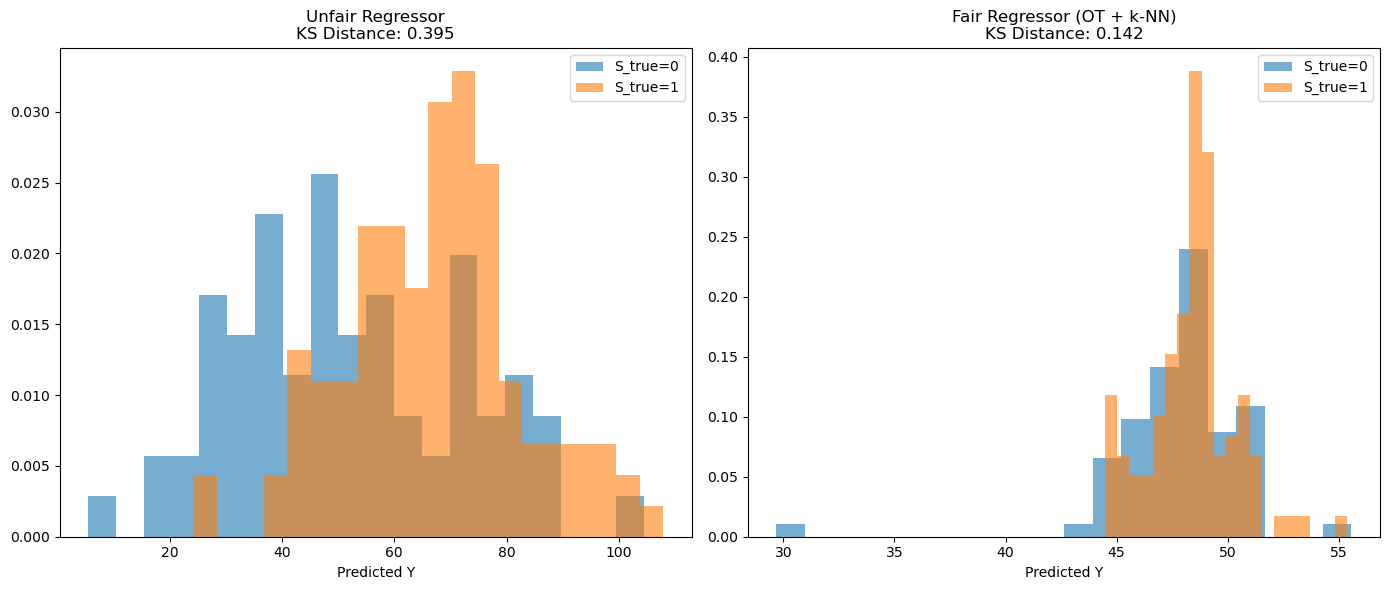

In [2]:

# 1. Generate Data (Biased depending on the sensitive attribute's value)
np.random.seed(42)
n = 600
S = np.random.binomial(1, 0.5, n) # Binary sensitive attributes
X = np.random.normal(0, 1, n) + S
X = X.reshape(-1, 1)
# Y depends on X (and thus S)
alpha = 100
Y = alpha*S + 0.5 * X.flatten() + np.random.normal(0, 1, n)
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, train_size = 0.7)

# 2. Train Models
# Standard
std_reg = LinearRegression().fit(X_test, Y_test)
y_std = std_reg.predict(X_test)

# Fair (OT + k-NN)
ot_reg = OTUnawareFairRegressor(n_neighbors=10)
ot_reg.fit(X_train, Y_train, S_train)
y_fair = ot_reg.predict(X_test)

# 3. Calculate KS Distance
ks_std = ks_2samp(y_std[S_test==1], y_std[S_test==2])
ks_fair = ks_2samp(y_fair[S_test==1], y_fair[S_test==2])

print(f"KS Distance (Unfair): {ks_std.statistic:.4f} (p={ks_std.pvalue:.4e})")
print(f"KS Distance (Fair):   {ks_fair.statistic:.4f} (p={ks_fair.pvalue:.4e})")

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distributions
axes[0].hist(y_std[S_test==1], bins=20, alpha=0.6, label='S_true=0', density=True, color='tab:blue')
axes[0].hist(y_std[S_test==2], bins=20, alpha=0.6, label='S_true=1', density=True, color='tab:orange')
axes[0].set_title(f"Unfair Regressor\nKS Distance: {ks_std.statistic:.3f}")
axes[0].set_xlabel("Predicted Y")
axes[0].legend()

# Plot 2: Fair Distributions
axes[1].hist(y_fair[S_test==1], bins=20, alpha=0.6, label='S_true=0', density=True, color='tab:blue')
axes[1].hist(y_fair[S_test==2], bins=20, alpha=0.6, label='S_true=1', density=True, color='tab:orange')
axes[1].set_title(f"Fair Regressor (OT + k-NN)\nKS Distance: {ks_fair.statistic:.3f}")
axes[1].set_xlabel("Predicted Y")
axes[1].legend()
plt.savefig("./results/generic_data_unaware.png")
plt.tight_layout()
plt.show()


Notes for p-value: 
Suppose we wish to test the null hypothesis that two samples were drawn from the same distribution. We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

The KS decreased significantly, but the p-value is still too small.

To be discussed : tranport plan for new data.